In [50]:
import os
import cv2
import glob
import torch
import albumentations as A
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2

import bsrgan_degradation.utils_image as util
import bsrgan_degradation.utils_blindsr as blindsr

In [77]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [51]:
class Div2KDataset(Dataset):
    def __init__(self, path, transform=None, img_ext="png", scale_factor=4, shuffle_prob=0.1, use_sharp=True, patch_size=72):
        self.transform = transform
        self.scale_factor = scale_factor
        self.shuffle_prob = shuffle_prob
        self.use_sharp = use_sharp
        self.patch_size = patch_size
        self.image_paths = glob.glob(os.path.join(path, f"**/*.{img_ext}"), recursive=True)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        # get the image
        img = util.imread_uint(image_path)  # read RGB image; shape (H, W, C); range [0, 255]
        img = util.uint2single(img)  # convert to range [0, 1] (expected by "blindsr.degradation_bsrgan_plus")

        # optionally apply augmentations on the image (e.g., rotation, horizontal flip, etc)
        if self.transform:
            img = self.transform(image=img)["image"]
        
        # img_lq shape (PATCH_SIZE, PATCH_SIZE, C)
        # img_lq shape (PATCH_SIZE * SCALE_FACTOR, PATCH_SIZE * SCALE_FACTOR, C)
        # range for both [0, 1]
        img_lq, img_hq = blindsr.degradation_bsrgan_plus(img, 
                                                         sf=self.scale_factor, 
                                                         shuffle_prob=self.shuffle_prob, 
                                                         use_sharp=self.use_sharp, 
                                                         lq_patchsize=self.patch_size)
        # convert from numpy arrays to PyTorch tensors
        img_lq, img_hq = map(lambda arr: torch.from_numpy(arr.transpose(2, 0, 1)), (img_lq, img_hq))
        
        return {"gt": img_hq, "lq": img_lq}

In [52]:
TRAIN_PATH = "./DIV2K_train_HR/"
VALID_PATH = "./DIV2K_valid_HR/"

In [79]:
# transforms to apply to images BEFORE applying BSRGAN+ degradation model
transforms = A.Compose([
    A.Rotate(interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
])

In [80]:
train_dset = Div2KDataset(path=TRAIN_PATH, transform=transforms)
valid_dset = Div2KDataset(path=VALID_PATH)

print(f"# train images: {len(train_dset)}")
print(f"# valid images: {len(valid_dset)}")

# train images: 800
# valid images: 100


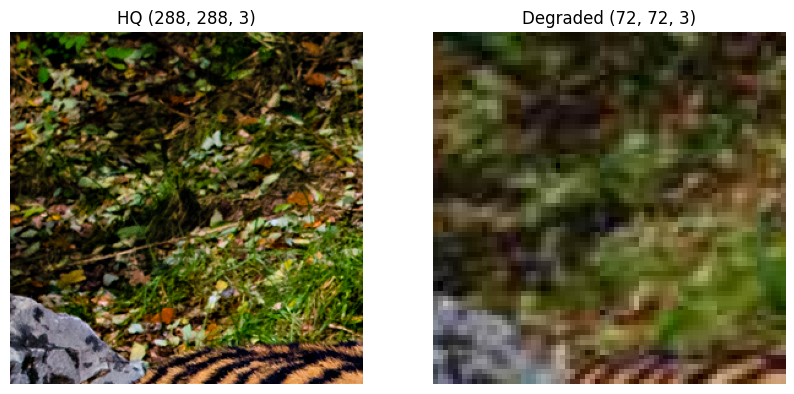

In [84]:
idx = 3
dset_item = train_dset[idx]

img_lq, img_hq = dset_item["lq"].permute(1, 2, 0), dset_item["gt"].permute(1, 2, 0)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(img_hq)
plt.axis("off")
plt.title(f"HQ {tuple(img_hq.shape)}")

plt.subplot(1, 2, 2)
plt.imshow(img_lq)
plt.axis("off")
plt.title(f"Degraded {tuple(img_lq.shape)}")

plt.show()